# Import Libraries


In [2]:
!pip install h2o

     |████████████████████████████████| 164.6MB 75kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.3-py2.py3-none-any.whl size=164649662 sha256=d52bafd818c11205cc8e7c7fc234e63ed174c8a64b2c482707a00af94e44611e
  Stored in directory: /root/.cache/pip/wheels/0a/fd/63/96d322a27867a81a2904172a75aed5241913d603a4b8c4b277
Successfully built h2o


In [3]:
# basic
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# h2o
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [59]:
# Sci-kit learn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc, roc_curve, classification_report, accuracy_score, mean_absolute_error

In [20]:
# Torch
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Data Processing

In [4]:
data = pd.read_csv('conversion_data.csv')
data

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
data.nunique()

country                 4
age                    60
new_user                2
source                  3
total_pages_visited    29
converted               2
dtype: int64

In [9]:
uniques = [data[col].unique() for col in data.columns if data.dtypes[col]=='object']
uniques

[array(['UK', 'US', 'China', 'Germany'], dtype=object),
 array(['Ads', 'Seo', 'Direct'], dtype=object)]

In [11]:
data.isnull().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

In [16]:
data = data[data['age'] < 90].reset_index(drop=True)

In [18]:
pd.get_dummies(data, columns=['country', 'source'])

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
316193,26,1,9,0,0,0,0,1,1,0,0
316194,27,1,6,0,0,0,0,1,0,1,0
316195,25,0,4,0,1,0,0,0,1,0,0
316196,22,0,4,0,0,0,0,1,0,0,1


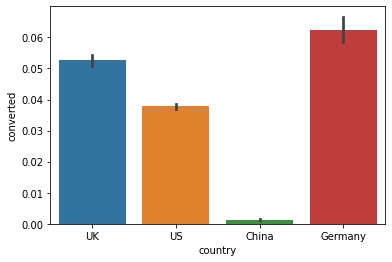

In [27]:
# country_group = data.groupby(['country'])['converted'].mean().reset_index()
# sns.countplot(x='country', hue='converted', data=data)
sns.barplot(x='country', y='converted', data=data)
plt.show()

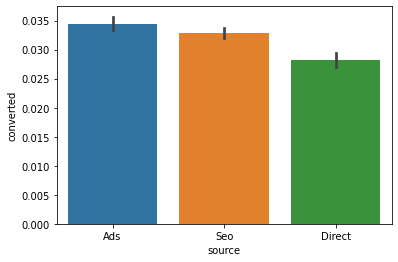

In [28]:
sns.barplot(x='source', y='converted', data=data)
plt.show()

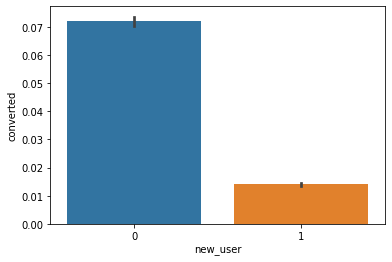

In [29]:
sns.barplot(x='new_user', y='converted', data=data)
plt.show()

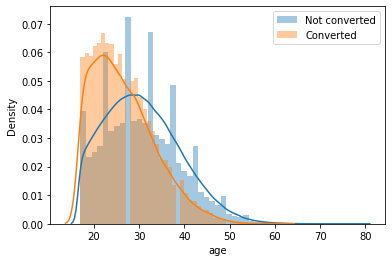

In [33]:
sns.distplot(data[data['converted'] == 0]['age'], label='Not converted')
sns.distplot(data[data['converted'] == 1]['age'], label='Converted')
plt.legend()
plt.show()

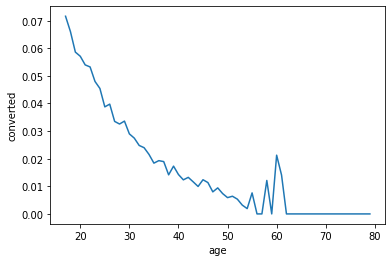

In [36]:
age_group = data.groupby('age')['converted'].mean().reset_index()
sns.lineplot(age_group['age'], age_group['converted'])

# Modeling (h2o)

In [37]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_065f5kn
  JVM stdout: /tmp/tmp_065f5kn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_065f5kn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_dcaogb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [39]:
h2o_df = H2OFrame(data)
h2o_df

Parse progress: |█████████████████████████████████████████████████████████| 100%


country,age,new_user,source,total_pages_visited,converted
UK,25,1,Ads,1,0
US,23,1,Seo,5,0
US,28,1,Seo,4,0
China,39,1,Seo,5,0
US,30,1,Seo,6,0
US,31,0,Seo,1,0
China,27,1,Seo,4,0
US,23,0,Ads,4,0
UK,29,0,Direct,4,0
US,25,0,Ads,2,0


In [40]:
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

In [41]:
h2o_df.summary()

,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [42]:
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

In [43]:
feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [44]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


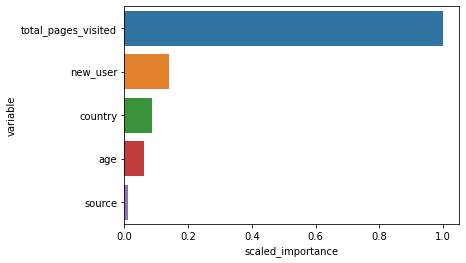

In [46]:
# model.varimp_plot()
importance = model.varimp(use_pandas=True)
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [57]:
model.predict(train).as_data_frame() # raw prediction

drf prediction progress: |████████████████████████████████████████████████| 100%


,predict,p0,p1
0,0,0.999776,0.000224
1,0,0.999514,0.000486
2,0,0.999784,0.000216
3,0,0.999949,0.000051
4,0,0.999463,0.000537
...,...,...,...
237143,0,0.999947,0.000053
237144,1,0.870606,0.129394
237145,0,0.997839,0.002161
237146,0,0.999791,0.000209


In [47]:
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred_p1 = model.predict(train).as_data_frame()['p1'].values
test_pred_p1 = model.predict(test).as_data_frame()['p1'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [49]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred_p1)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred_p1)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [51]:
print(train_auc, test_auc)

0.994 0.978


In [52]:
print(classification_report(y_true=test_true, y_pred=(test_pred_p1 > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.64      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.82      0.86     79050
weighted avg       0.98      0.98      0.98     79050



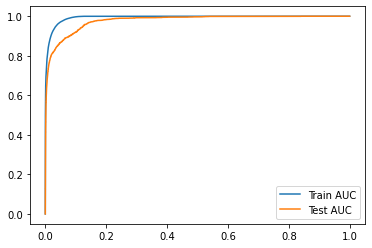

In [54]:
plt.plot(train_fpr, train_tpr, label='Train AUC')
plt.plot(test_fpr, test_tpr, label='Test AUC')
plt.legend()
plt.show()

In [60]:
# classcification accuracy
train_pred = model.predict(train).as_data_frame()['predict'].values
test_pred = model.predict(test).as_data_frame()['predict'].values
train_accu = accuracy_score(train_true, train_pred)
test_accu = accuracy_score(test_true, test_pred)
print(train_accu, test_accu)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
0.9504908327289288 0.9455028462998103


PartialDependencePlot progress: |█████████████████████████████████████████| 100%

PartialDependence: Partial Dependence Plot of model DRF_model_python_1610315007466_1 on column 'country'.


,country,mean_response,stddev_response,std_error_mean_response
0,China,0.002176,0.017878,0.000037
1,Germany,0.031294,0.147333,0.000303
2,UK,0.033853,0.144128,0.000296
3,US,0.029268,0.122297,0.000251



PartialDependence: Partial Dependence Plot of model DRF_model_python_1610315007466_1 on column 'age'.


,age,mean_response,stddev_response,std_error_mean_response
0,17.000000,0.035553,0.137923,0.000283
1,20.263158,0.034691,0.139038,0.000286
2,23.526316,0.030728,0.133200,0.000274
3,26.789474,0.028598,0.128268,0.000263
4,30.052632,0.026105,0.120387,0.000247
5,33.315789,0.023417,0.112948,0.000232
6,36.578947,0.021005,0.111652,0.000229
7,39.842105,0.018553,0.107055,0.000220
8,43.105263,0.015003,0.086771,0.000178
9,46.368421,0.013974,0.092298,0.000190



PartialDependence: Partial Dependence Plot of model DRF_model_python_1610315007466_1 on column 'new_user'.


,new_user,mean_response,stddev_response,std_error_mean_response
0,0,0.039582,0.148094,0.000304
1,1,0.017573,0.092473,0.000190



PartialDependence: Partial Dependence Plot of model DRF_model_python_1610315007466_1 on column 'source'.


,source,mean_response,stddev_response,std_error_mean_response
0,Ads,0.027800,0.127673,0.000262
1,Direct,0.025539,0.123701,0.000254
2,Seo,0.028166,0.126813,0.000260



PartialDependence: Partial Dependence Plot of model DRF_model_python_1610315007466_1 on column 'total_pages_visited'.


,total_pages_visited,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.000278,0.000220,4.513547e-07
1,2.473684,0.000505,0.002187,4.491576e-06
2,3.947368,0.001051,0.004032,8.280196e-06
3,5.421053,0.001532,0.005243,1.076718e-05
4,6.894737,0.006019,0.015014,3.083116e-05
5,8.368421,0.012925,0.029890,6.137931e-05
6,9.842105,0.054035,0.087426,1.795281e-04
7,11.315789,0.095240,0.141360,2.902793e-04
8,12.789474,0.231754,0.262387,5.388058e-04
9,14.263158,0.322002,0.304628,6.255462e-04


[, , , , ]

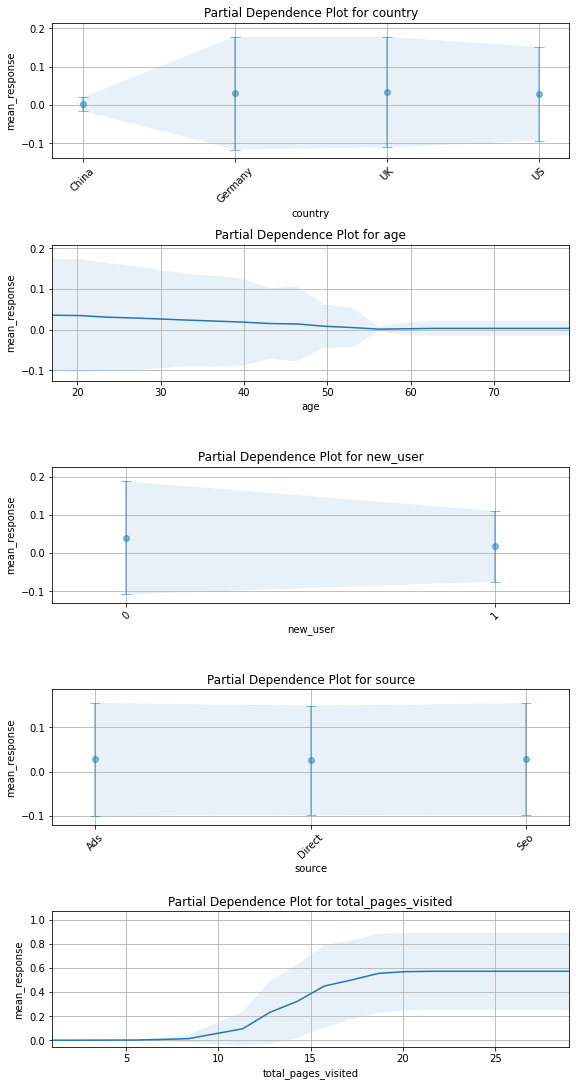

In [55]:
model.partial_plot(train, cols=feature, figsize=(8, 15))

# OHE + Sklearn


In [61]:
data_dummy = pd.get_dummies(data, columns=['country', 'source'])
data_dummy

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
316193,26,1,9,0,0,0,0,1,1,0,0
316194,27,1,6,0,0,0,0,1,0,1,0
316195,25,0,4,0,1,0,0,0,1,0,0
316196,22,0,4,0,0,0,0,1,0,0,1


In [63]:
X = data_dummy.drop(columns='converted').values
y = data_dummy.converted.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [65]:
xgb_model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
train_pred_2 = xgb_model.predict(X_train)
test_pred_2 = xgb_model.predict(X_test)
train_accu_2 = accuracy_score(train_pred_2, y_train)
test_accu_2 = accuracy_score(test_pred_2, y_test)
print(train_accu_2, test_accu_2)

0.9870081130770658 0.9863377609108159
